# Predecir nivel de adaptabilidad

In [1]:
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import csv

import tensorflow as tf

from tensorflow import keras
from keras import layers
from sklearn.preprocessing import OneHotEncoder

print(tf.__version__)

2023-11-25 16:13:44.047775: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-25 16:13:44.103606: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-25 16:13:44.103655: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-25 16:13:44.103704: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 16:13:44.114210: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-25 16:13:44.115018: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

2.14.0


## Exploracion de los datos
The data is obtained from the csv file "training-ds"

In [2]:
raw_dataset = pd.read_csv("./training-ds.csv")
dataset = raw_dataset.copy()
raw_dataset.head()


,Tipo de Red,Estudiante de Tecnología,Nivel de Educación,Vive en Ciudad,Tipo de Instituto,Edad,Dispositivo,Tipo de Internet,Situación Financiera,Género,Duración de la Clase,Nivel de Adaptación
0,3G,Si,Universidad,Si,Privado,21-25,Computadora,Wifi,Media,Masculino,03-Jun,Bajo
1,3G,No,Escuela,Si,Privado,Nov-15,Smartphone,Compra Megas,Media,Femenino,01-Mar,Moderado
2,3G,Si,Universidad,Si,Privado,21-25,Smartphone,Compra Megas,Mala,Masculino,01-Mar,Bajo
3,3G,Si,Escuela,Si,Privado,Nov-15,Smartphone,Compra Megas,Media,Masculino,01-Mar,Moderado
4,4G,Si,Universidad,Si,Privado,21-25,Computadora,Wifi,Buena,Masculino,01-Mar,Alto


### Cleaning Data

If the dataset contains any unknown value the row containing it will be deleted

In [3]:
dataset.isna().sum()

Tipo de Red                 0
Estudiante de Tecnología    0
Nivel de Educación          0
Vive en Ciudad              0
Tipo de Instituto           0
Edad                        0
Dispositivo                 0
Tipo de Internet            0
Situación Financiera        0
Género                      0
Duración de la Clase        0
Nivel de Adaptación         0
dtype: int64

As the dataset does not contain any unknown values, no row will be deleted.

### Correcting the data
The "Edad" column should contain values that indicate an age interval following this format: "21-24". 
But there are values that changed the value of a limit for a month like this: "Nov-15"

The data is corrected using the "correct_age" function.

In [4]:
def correct_number(edad): 
    months = {'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04', 'May': '05', 'Jun': '06', 
             'Jul': '07', 'Aug': '08', 'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'}

    for m in months: 
        if m in edad: 
            return edad.replace(m, months[m]) 
        
    return edad

This function is applied to the "Edad" column.

In [5]:
dataset['Edad'] = dataset["Edad"].apply(correct_number)
dataset.head()

,Tipo de Red,Estudiante de Tecnología,Nivel de Educación,Vive en Ciudad,Tipo de Instituto,Edad,Dispositivo,Tipo de Internet,Situación Financiera,Género,Duración de la Clase,Nivel de Adaptación
0,3G,Si,Universidad,Si,Privado,21-25,Computadora,Wifi,Media,Masculino,03-Jun,Bajo
1,3G,No,Escuela,Si,Privado,11-15,Smartphone,Compra Megas,Media,Femenino,01-Mar,Moderado
2,3G,Si,Universidad,Si,Privado,21-25,Smartphone,Compra Megas,Mala,Masculino,01-Mar,Bajo
3,3G,Si,Escuela,Si,Privado,11-15,Smartphone,Compra Megas,Media,Masculino,01-Mar,Moderado
4,4G,Si,Universidad,Si,Privado,21-25,Computadora,Wifi,Buena,Masculino,01-Mar,Alto


Same as the "Edad" column the "Duracion de la clase" column has the number values changed. 
The same function is applied to this column

In [6]:
dataset['Duración de la Clase'] = dataset["Duración de la Clase"].apply(correct_number)
dataset.head()

,Tipo de Red,Estudiante de Tecnología,Nivel de Educación,Vive en Ciudad,Tipo de Instituto,Edad,Dispositivo,Tipo de Internet,Situación Financiera,Género,Duración de la Clase,Nivel de Adaptación
0,3G,Si,Universidad,Si,Privado,21-25,Computadora,Wifi,Media,Masculino,03-06,Bajo
1,3G,No,Escuela,Si,Privado,11-15,Smartphone,Compra Megas,Media,Femenino,01-03,Moderado
2,3G,Si,Universidad,Si,Privado,21-25,Smartphone,Compra Megas,Mala,Masculino,01-03,Bajo
3,3G,Si,Escuela,Si,Privado,11-15,Smartphone,Compra Megas,Media,Masculino,01-03,Moderado
4,4G,Si,Universidad,Si,Privado,21-25,Computadora,Wifi,Buena,Masculino,01-03,Alto


### One hot encoding

In [7]:
columns = list(dataset.keys())
columns

['Tipo de Red',
 'Estudiante de Tecnología',
 'Nivel de Educación',
 'Vive en Ciudad',
 'Tipo de Instituto',
 'Edad',
 'Dispositivo',
 'Tipo de Internet',
 'Situación Financiera',
 'Género',
 'Duración de la Clase',
 'Nivel de Adaptación']

In [8]:
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoded = one_hot_encoder.fit_transform(dataset[columns])
one_hot_encoded

/home/redo/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.]])

In [9]:
encoded_dataset = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out())
encoded_dataset 

,Tipo de Red_2G,Tipo de Red_3G,Tipo de Red_4G,Estudiante de Tecnología_No,Estudiante de Tecnología_Si,Nivel de Educación_Colegio,Nivel de Educación_Escuela,Nivel de Educación_Universidad,Vive en Ciudad_No,Vive en Ciudad_Si,...,Situación Financiera_Mala,Situación Financiera_Media,Género_Femenino,Género_Masculino,Duración de la Clase_0,Duración de la Clase_01-03,Duración de la Clase_03-06,Nivel de Adaptación_Alto,Nivel de Adaptación_Bajo,Nivel de Adaptación_Moderado
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
959,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
960,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
961,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
962,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [10]:
def plot_pies(dataset):
    display=len(dataset.columns.values)
    fig, axes = plt.subplots(3,4,figsize=(10, 10))
    fig.subplots_adjust(wspace=.5)
    counter=0
    x=(0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2)
    z=(0, 1, 2, 3, 0, 1, 2, 3, 0, 1 ,2 ,3)
    for i in dataset.columns.values:
            val1=x[counter]
            val2=z[counter]
            y=dataset.pivot_table(index = [i], aggfunc ='size')
            axes[val1][val2].pie(y, labels =list(y.keys()))
            axes[val1][val2].set_title(i, fontsize = 12)
            counter=counter+1
    plt.show()


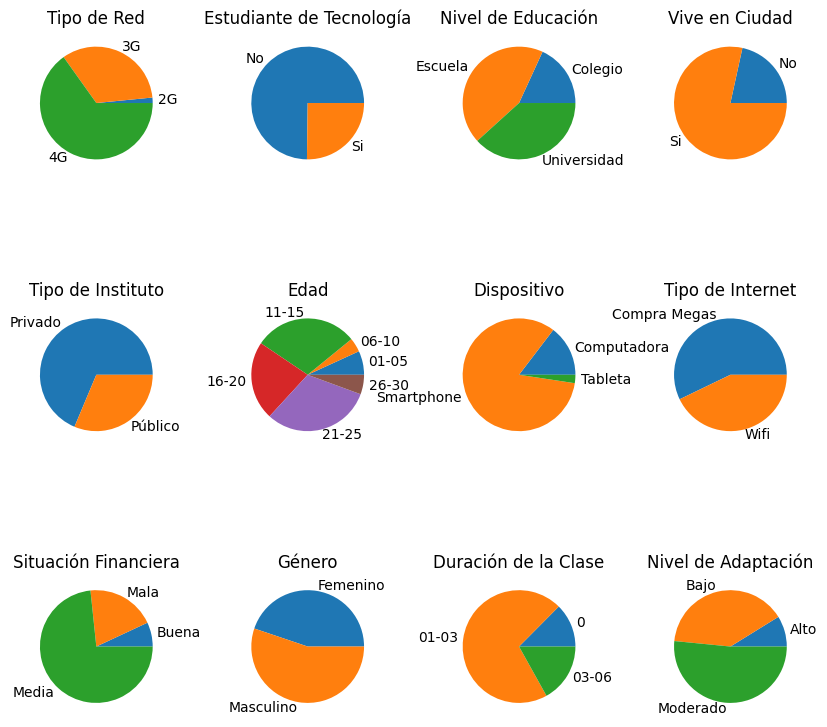

In [11]:
#encoded_dataset.plot.pie(y='Género', figsize=(5, 5))

plot_pies(dataset)

In [12]:
correlation_matrix = encoded_dataset.corr()
correlations = correlation_matrix.loc[['Nivel de Adaptación_Alto', "Nivel de Adaptación_Moderado", "Nivel de Adaptación_Bajo"]]
correlations = correlations.transpose()
correlations = correlations.drop(['Nivel de Adaptación_Alto', "Nivel de Adaptación_Moderado", "Nivel de Adaptación_Bajo"])
correlations

,Nivel de Adaptación_Alto,Nivel de Adaptación_Moderado,Nivel de Adaptación_Bajo
Tipo de Red_2G,-0.039096,-0.096155,0.120911
Tipo de Red_3G,-0.064461,-0.028605,0.066596
Tipo de Red_4G,0.073909,0.053266,-0.097270
Estudiante de Tecnología_No,-0.063813,-0.094265,0.133308
Estudiante de Tecnología_Si,0.063813,0.094265,-0.133308
Nivel de Educación_Colegio,-0.117979,-0.092745,0.163156
Nivel de Educación_Escuela,0.014511,0.077296,-0.087390
Nivel de Educación_Universidad,0.078757,-0.005303,-0.040238
Vive en Ciudad_No,-0.091963,-0.187896,0.245294
Vive en Ciudad_Si,0.091963,0.187896,-0.245294


In [13]:
correlations['mean'] = correlations[['Nivel de Adaptación_Alto', "Nivel de Adaptación_Moderado", "Nivel de Adaptación_Bajo"]].abs().mean(axis=1)
correlations = correlations[correlations['mean'] >= 0.10]
correlations

,Nivel de Adaptación_Alto,Nivel de Adaptación_Moderado,Nivel de Adaptación_Bajo,mean
Nivel de Educación_Colegio,-0.117979,-0.092745,0.163156,0.124627
Vive en Ciudad_No,-0.091963,-0.187896,0.245294,0.175051
Vive en Ciudad_Si,0.091963,0.187896,-0.245294,0.175051
Tipo de Instituto_Privado,0.060171,0.258213,-0.298710,0.205698
Tipo de Instituto_Público,-0.060171,-0.258213,0.298710,0.205698
Edad_01-05,-0.084304,0.139505,-0.093667,0.105825
Edad_06-10,0.158966,-0.148617,0.059694,0.122426
Edad_16-20,-0.124376,-0.071411,0.145066,0.113618
Dispositivo_Computadora,0.140463,0.042915,-0.125276,0.102885
Dispositivo_Smartphone,-0.122091,-0.090864,0.163617,0.125524


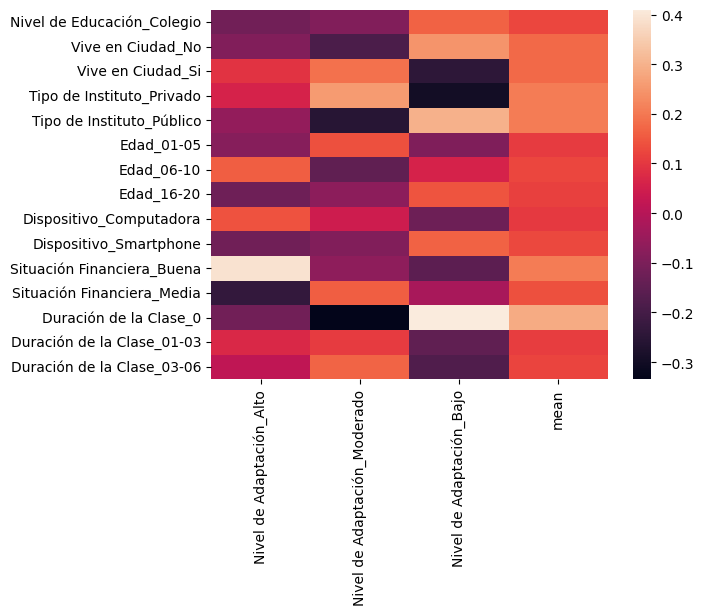

In [14]:

sns.heatmap(correlations, annot=False)
plt.show()

La poca cantidad de cantidad puede generar BIAS

In [15]:
encoded_dataset.head()

,Tipo de Red_2G,Tipo de Red_3G,Tipo de Red_4G,Estudiante de Tecnología_No,Estudiante de Tecnología_Si,Nivel de Educación_Colegio,Nivel de Educación_Escuela,Nivel de Educación_Universidad,Vive en Ciudad_No,Vive en Ciudad_Si,...,Situación Financiera_Mala,Situación Financiera_Media,Género_Femenino,Género_Masculino,Duración de la Clase_0,Duración de la Clase_01-03,Duración de la Clase_03-06,Nivel de Adaptación_Alto,Nivel de Adaptación_Bajo,Nivel de Adaptación_Moderado
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [16]:
labels = dataset.pop('Nivel de Adaptación')
dict = {"Bajo": 0, "Moderado": 1, "Alto": 2}
enconded_labels = []
for label in labels: 
    enconded_labels.append(dict[label])
enconded_labels = np.array(enconded_labels)

encoded_dataset = encoded_dataset.drop(['Nivel de Adaptación_Alto', "Nivel de Adaptación_Moderado", "Nivel de Adaptación_Bajo"], axis=1)
encoded_dataset.insert(0, "label", enconded_labels, True)
encoded_dataset.head()

,label,Tipo de Red_2G,Tipo de Red_3G,Tipo de Red_4G,Estudiante de Tecnología_No,Estudiante de Tecnología_Si,Nivel de Educación_Colegio,Nivel de Educación_Escuela,Nivel de Educación_Universidad,Vive en Ciudad_No,...,Tipo de Internet_Compra Megas,Tipo de Internet_Wifi,Situación Financiera_Buena,Situación Financiera_Mala,Situación Financiera_Media,Género_Femenino,Género_Masculino,Duración de la Clase_0,Duración de la Clase_01-03,Duración de la Clase_03-06
0,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
2,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [17]:
encoded_dataset.keys()

Index(['label', 'Tipo de Red_2G', 'Tipo de Red_3G', 'Tipo de Red_4G',
       'Estudiante de Tecnología_No', 'Estudiante de Tecnología_Si',
       'Nivel de Educación_Colegio', 'Nivel de Educación_Escuela',
       'Nivel de Educación_Universidad', 'Vive en Ciudad_No',
       'Vive en Ciudad_Si', 'Tipo de Instituto_Privado',
       'Tipo de Instituto_Público', 'Edad_01-05', 'Edad_06-10', 'Edad_11-15',
       'Edad_16-20', 'Edad_21-25', 'Edad_26-30', 'Dispositivo_Computadora',
       'Dispositivo_Smartphone', 'Dispositivo_Tableta',
       'Tipo de Internet_Compra Megas', 'Tipo de Internet_Wifi',
       'Situación Financiera_Buena', 'Situación Financiera_Mala',
       'Situación Financiera_Media', 'Género_Femenino', 'Género_Masculino',
       'Duración de la Clase_0', 'Duración de la Clase_01-03',
       'Duración de la Clase_03-06'],
      dtype='object')

In [18]:
train_dataset = encoded_dataset.sample(frac=0.8,random_state=0)
test_dataset = encoded_dataset.drop(train_dataset.index)
train_dataset

,label,Tipo de Red_2G,Tipo de Red_3G,Tipo de Red_4G,Estudiante de Tecnología_No,Estudiante de Tecnología_Si,Nivel de Educación_Colegio,Nivel de Educación_Escuela,Nivel de Educación_Universidad,Vive en Ciudad_No,...,Tipo de Internet_Compra Megas,Tipo de Internet_Wifi,Situación Financiera_Buena,Situación Financiera_Mala,Situación Financiera_Media,Género_Femenino,Género_Masculino,Duración de la Clase_0,Duración de la Clase_01-03,Duración de la Clase_03-06
952,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
278,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
14,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
680,1,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
338,1,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
117,1,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
464,1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
25,1,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


In [19]:
y_train = train_dataset.pop('label').to_numpy()
x_train = train_dataset.to_numpy()

y_test = test_dataset.pop('label').to_numpy()
x_test = test_dataset.to_numpy()

In [20]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(771, 31)
(771,)
(193, 31)
(193,)


# Models

Construir el modelo

In [21]:
def getModel(first_layer, second_layer, activation_fun, optimizer_opt): 
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(26,)))
    model.add(tf.keras.layers.Dense(first_layer, activation=activation_fun))
    model.add(tf.keras.layers.Dense(second_layer, activation=activation_fun))
    model.add(tf.keras.layers.Dense(3, activation='softmax'))
    
    model.compile(optimizer=optimizer_opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

    return model

In [22]:

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
    plt.ylim([0,1])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
    plt.ylim([0,1])
    plt.legend()
    plt.show()

In [28]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(31,)))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation='softmax'))
# tambien podemos utilizar softplus
# al parecer relu no se lleva bien con muchas neuronas o muhas capas 
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Epoch 1/200


25/25 [==============================] - 1s 6ms/step - loss: 0.9383 - accuracy: 0.5603 - val_loss: 0.7899 - val_accuracy: 0.6114
Epoch 2/200
25/25 [==============================] - 0s 2ms/step - loss: 0.8114 - accuracy: 0.6394 - val_loss: 0.7377 - val_accuracy: 0.6839
Epoch 3/200
25/25 [==============================] - 0s 2ms/step - loss: 0.7480 - accuracy: 0.6537 - val_loss: 0.7046 - val_accuracy: 0.7047
Epoch 4/200
25/25 [==============================] - 0s 2ms/step - loss: 0.7040 - accuracy: 0.7017 - val_loss: 0.6880 - val_accuracy: 0.6943
Epoch 5/200
25/25 [==============================] - 0s 2ms/step - loss: 0.6680 - accuracy: 0.7173 - val_loss: 0.6663 - val_accuracy: 0.7306
Epoch 6/200
25/25 [==============================] - 0s 2ms/step - loss: 0.6364 - accuracy: 0.7419 - val_loss: 0.6571 - val_accuracy: 0.7098
Epoch 7/200
25/25 [==============================] - 0s 2ms/step - loss: 0.6181 - accuracy: 0.7588 - val_loss: 0.6321 - val_accuracy: 0.7409
Epoch 8/200
25/25 [======

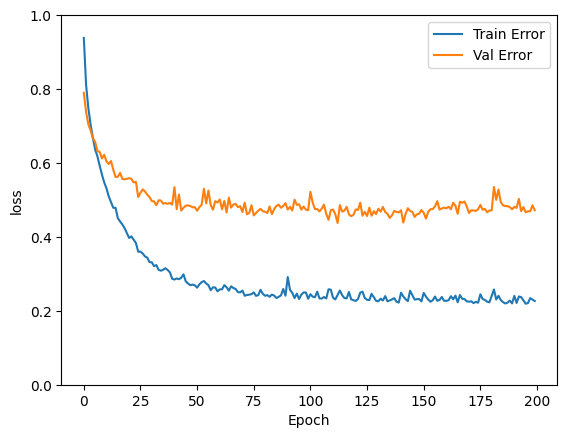

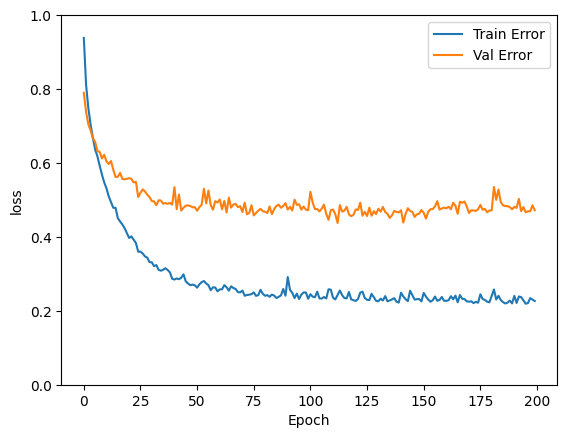

7/7 - 0s - loss: 0.4721 - accuracy: 0.8135 - 21ms/epoch - 3ms/step

Test accuracy: 0.8134714961051941


In [29]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs = 200)
plot_history(hist)

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

In [32]:
map_dict = {0: 'Bajo', 1: 'Moderado', 2: 'Alto'}

def mapper(lst):
  return list(map(lambda x: map_dict[x], lst))

sub_dataset = pd.read_csv('./submission-ds.csv')
sub_dataset['Edad'] = dataset["Edad"].apply(correct_number)
sub_dataset['Duración de la Clase'] = sub_dataset["Duración de la Clase"].apply(correct_number)
sub_columns  = columns[:-1]
sub_x = one_hot_encoder.fit_transform(sub_dataset[sub_columns])
sub_predictions = model.predict(sub_x)

8/8 [==============================] - 0s 1ms/step


/home/redo/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [33]:
indices = []
for pred in sub_predictions:
  indices.append(np.argmax(pred))

predicted_labels = mapper(indices)
my_list = [["id", "Nivel de Adaptación"]]
for i in range(len(predicted_labels)):
  my_list.append([i+1, predicted_labels[i]])
  with open('relu_64_64_mejor_creo.csv', 'w', newline='') as file:
    # Step 4: Using csv.writer to write the list to the CSV file
    writer = csv.writer(file)
    writer.writerows(my_list) # Use writerows for nested list

In [ ]:
# El modelo: 
# model = tf.keras.Sequential()
# model.add(tf.keras.Input(shape=(26,)))
# model.add(tf.keras.layers.Dense(64, activation='relu'))
# model.add(tf.keras.layers.Dense(64, activation='relu'))
# model.add(tf.keras.layers.Dense(3, activation='softmax'))

# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# con 200 epochs
# obtinene: 0.8549222946166992 de accuracy

In [ ]:
models = []
1
activations = ['relu', 'leaky_relu', 'tanh']
optimizers = ["RMSprop", "Adam", "Nadam"]
losses = ["SparseCategoricalCrossentropy"]
for act in activations: 
    model0 = getModel(64, 64, act) 
    model1 = getModel(128, 128, act)
    model2 = getModel(128, 64, act)
    model3 = getModel(64, 128, act)

    models.append(model0)
    models.append(model1)
    models.append(model2)
    models.append(model3)

accus = []
i = 1
for model in models: 
    model.fit(ready2train, labels_train,validation_data = (ready2test, labels_test), epochs = 200)
    test_loss, test_acc = model.evaluate(ready2test,  labels_test, verbose=2)
    accus.append(test_acc)


    

Epoch 1/200
25/25 [==============================] - 1s 7ms/step - loss: 0.9895 - accuracy: 0.5058 - val_loss: 0.8223 - val_accuracy: 0.6269
Epoch 2/200
25/25 [==============================] - 0s 3ms/step - loss: 0.8667 - accuracy: 0.5966 - val_loss: 0.7608 - val_accuracy: 0.6632
Epoch 3/200
25/25 [==============================] - 0s 3ms/step - loss: 0.8002 - accuracy: 0.6667 - val_loss: 0.7218 - val_accuracy: 0.6891
Epoch 4/200
25/25 [==============================] - 0s 3ms/step - loss: 0.7456 - accuracy: 0.6783 - val_loss: 0.6912 - val_accuracy: 0.6632
Epoch 5/200
25/25 [==============================] - 0s 3ms/step - loss: 0.7016 - accuracy: 0.7082 - val_loss: 0.6597 - val_accuracy: 0.6943
Epoch 6/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6621 - accuracy: 0.7211 - val_loss: 0.6500 - val_accuracy: 0.7047
Epoch 7/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6296 - accuracy: 0.7354 - val_loss: 0.6237 - val_accuracy: 0.7254
Epoch 8/200
2

In [ ]:
for ac in accus: 
    if(i%4 == 1): 
        print("Nuevo funcion de activacion")
    print(f"modelo: {i}")
    i+=1
    print('Test accuracy:', ac)

NameError: name 'accus' is not defined

# Training

In [ ]:
import xgboost as xgb
dtrain = xgb.DMatrix(ready2train, label=labels_train)
dtest = xgb.DMatrix(ready2test, label=labels_test)
num_classes = 3 
params = {
    'objective': 'multi:softprob',
    'num_class': num_classes,
    # add other parameters as necessary
}
model = xgb.train(params, dtrain)


In [ ]:
y_pred_prob = model.predict(dtest)

y_pred = np.argmax(y_pred_prob, axis=1)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(labels_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 77.20%


In [ ]:
map_dict = {0: 'Bajo', 1: 'Moderado', 2: 'Alto'}

def mapper(lst):
  return list(map(lambda x: map_dict[x], lst))

sub_dataset = pd.read_csv('./submission-ds.csv')
sub_dataset['Edad'] = dataset["Edad"].apply(correct_number)
sub_dataset['Duración de la Clase'] = sub_dataset["Duración de la Clase"].apply(correct_number)
# sub_dataset.pop('Nivel de Adaptación')

sub_dataset = hot_one_dataset(sub_dataset)
sub_dataset

sub_x = sub_dataset.to_numpy()
sub_x
dsub = xgb.DMatrix(sub_x)
sub_predictions = model.predict(dsub)


In [ ]:
indices = []
for pred in sub_predictions:
  indices.append(np.argmax(pred))

predicted_labels = mapper(indices)
my_list = [["id", "Nivel de Adaptación"]]
for i in range(len(predicted_labels)):
  my_list.append([i+1, predicted_labels[i]])
  with open('txgboost.csv', 'w', newline='') as file:
    # Step 4: Using csv.writer to write the list to the CSV file
    writer = csv.writer(file)
    writer.writerows(my_list) # Use writerows for nested list